# Support Vector Machines

Have a look at [Chapter 5.07 of PDSH on Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)[![Cover image of PDSH](images/PDSH-cover-small.png)](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

SVMs are another classification method. Here's the example from PDSH, modified to use plotnine:




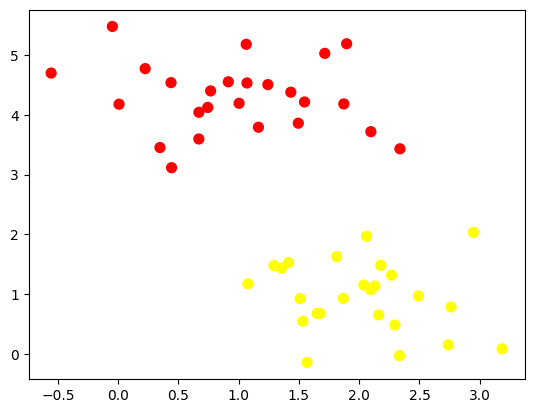

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.datasets import make_blobs, make_circles
from sklearn.datasets import fetch_lfw_people

from sklearn.svm import SVC # "Support vector classifier"
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# I didn't change all the plotting code to plotnine
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d



# Creat some data:
#   X is a 2D-ndarray with x,y coordinates
#   y is 1/0 categorical value for each X

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

> A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!
>
> We can draw them as follows:

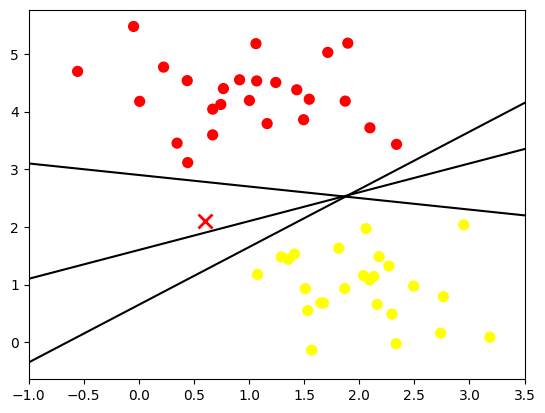

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

> These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

With the Support Vector Machine algorithm, the objective is to find a line (in the case of 2D, or **hyperplane** in N-dimensional space) that has the **maximum margin**, or distance between data points of each class. 

The SVM options include a `kernel`--we'll use `linear` for now and come back to this later--and `C`. $C$ is the cost parameter that controls the width of the margin, or how costly is it to misclassify something.

In [5]:
model =Pipeline([ 
   ('SVM', SVC(kernel='linear', C=1E10))
])
model.fit(X, y)

Pipeline(steps=[('SVM', SVC(C=10000000000.0, kernel='linear'))])

In [6]:
# This is the plotting function from PDSH, I didn't try to
# rewrite it using plotnine, so it uses matplotlib

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model['SVM'].decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model['SVM'].support_vectors_[:, 0],
                   model['SVM'].support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolor='black', facecolors='none')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

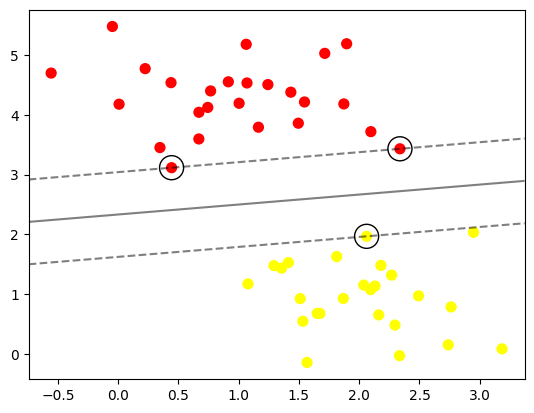

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

> This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

One way to think of the support vectors is that they are the critical elements of the training set and those which would change the position of the dividing hyperplane if removed.

In Scikit-Learn, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [8]:
model['SVM'].support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

The graph above and the image on the left below show the line in a 2D example, while the graph on the right shows the plane (hyperplane) from a 3D feature space. It gets hard to draw after that... (image from Rohith Gandhi's [Support Vector Machine — Introduction to Machine Learning Algorithms](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47))

![Hyperplanes in 2D and 3D feature space from Rohith Gandhi](images/SVM_hyperplane.png)

## The Hinge Loss Function

Without getting into the math, SVMs make use of a loss function called **hinge loss** (If you want more details, there are many sources online, though I found [Clare Liu's post here](https://www.vebuso.com/2020/02/a-top-machine-learning-algorithm-explained-support-vector-machines-svms/) particularly easy to follow and not too mathematical) Hinge loss penalizes misclassified points more the further they are from the decision boundary. As such, a point close to the hyperplane splitting classes will be penalized less than a point further away from the line. As with other loss functions, the idea is to sum the loss over all the training data and minimize the loss.


## The Kernel "Trick" and Mapping to a Higher Dimension

Another characteristic of SVMs is their use of kernel functions, also sometimes called the 'kernel trick'. For data that are not linearly separable, as below, SVMs can use a kernel function to transform the data to a higher dimension to make it linearly separable.

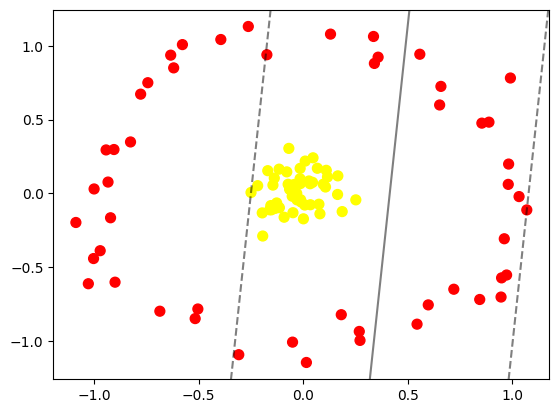

In [9]:
# Make data that are not linearly separable
X, y = make_circles(100, factor=.1, noise=.1)

clf  =Pipeline([ 
   ('SVM', SVC(kernel='linear'))
])
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

interactive(children=(Dropdown(description='elev', index=1, options=(-30, 30, -45, 45), value=30), IntSlider(v…

<function __main__.plot_3D(elev=30, azim=30, X=array([[ 1.31288664e-01,  1.07930052e+00],
       [ 1.07270486e-01,  4.29280117e-02],
       [-9.42225609e-01,  2.94244472e-01],
       [-9.06266982e-02, -1.61924355e-01],
       [ 9.83254848e-01,  1.98445407e-01],
       [-1.26265502e-01, -6.52448746e-02],
       [ 8.06279983e-03, -7.92262738e-02],
       [ 1.16848247e-01,  1.11041993e-01],
       [-2.73014132e-02, -3.29865363e-02],
       [-5.16170887e-01, -8.49136976e-01],
       [ 1.01960941e-02,  2.18669549e-01],
       [ 1.58728679e-02, -1.14666883e+00],
       [ 3.48746254e-02, -7.73516461e-02],
       [-7.79047127e-02,  1.45487228e-01],
       [ 9.66183380e-02,  6.17288880e-02],
       [ 9.81438154e-01,  6.07776276e-02],
       [-2.62017104e-01,  1.13112807e+00],
       [-3.02992140e-02, -4.98379780e-04],
       [-7.14639479e-02,  6.14795792e-02],
       [-9.70544330e-01, -3.88925620e-01],
       [-1.95372178e-01, -1.32614522e-01],
       [-5.03746011e-02, -1.00875032e+00],
       

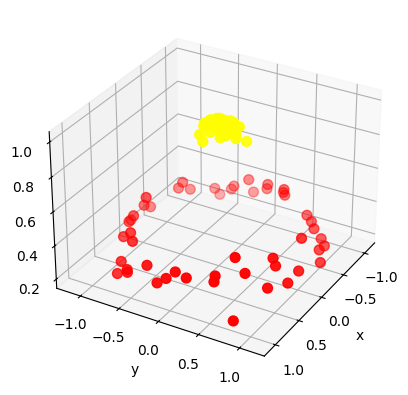

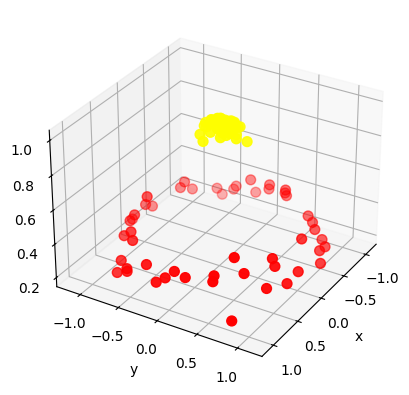

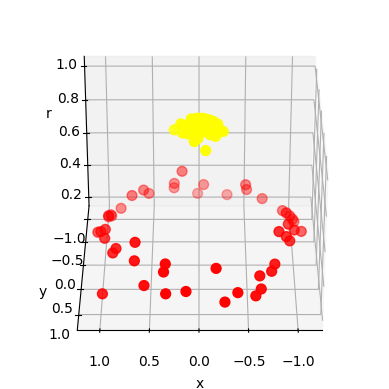

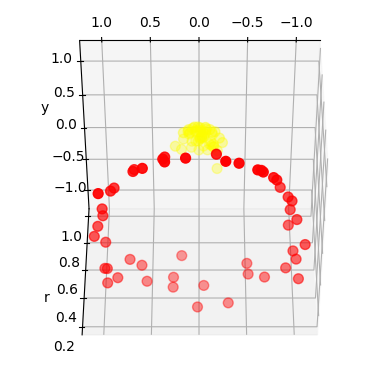

In [ ]:
# See PDSH Ch 5.07: Beyond linear boundaries: Kernel SVM
# 
r = np.exp(-(X ** 2).sum(1)) # Apply radial basis function (rbf) centered on center cluster

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-30, 30,-45, 45], azip=(-180, 180),
         X=fixed(X), y=fixed(y))

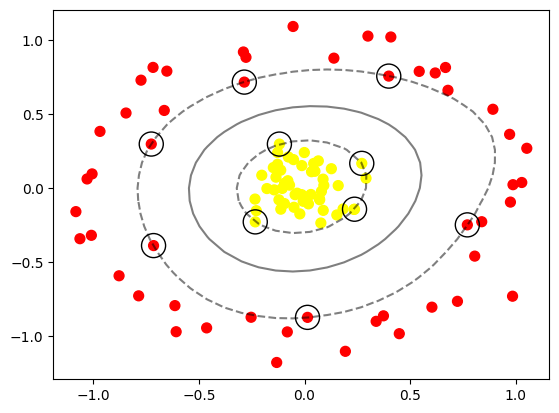

In [11]:

X, y = make_circles(100, factor=.1, noise=.1)

clf  =Pipeline([ 
   ('SVM', SVC(kernel='rbf', C=1E10))  # All we need to do is change 'linear' to 'rbf'
])
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=True)

**But...**

> Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.
>
> One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.
>
> A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large. However, because of a neat little procedure known as the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.


Kernels allow us to transform the data into a higher dimension, one where they are linearly separable, while at the same time, avoid needing to actually do the calculations to transform the data. 

The [`sklearn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) shows the available kernels: `linear`, `poly`, `rbf`, `sigmoid`, `precomputed`, or callable, default=`rbf`.


## Tuning the SVM: Softening Margins

So far, we have looked at fairly easily separable classes. We also briefly mentioned $C$, but didn't really look at the effect of changing $C$.

When data have more overlap, we can use the SVMs fudge-factor to soften the margin, allowing some points to be within the margin to allow better fit. For very large values of $C$, the margin is hard. For smaller values of $C$, the margin is softer. I've added the 1E10 value used above to what the PDSH text shows.


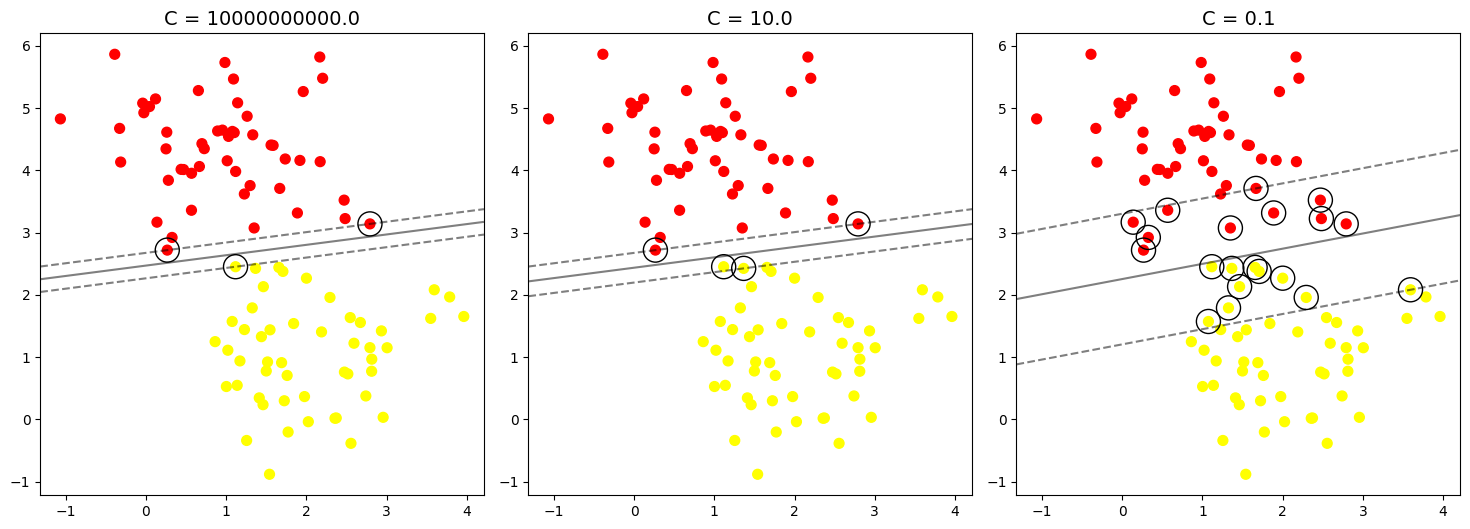

In [12]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [1E10, 10.0, 0.1]):
    model = Pipeline([('SVM', SVC(kernel='linear', C=C))])
    model.fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model['SVM'].support_vectors_[:, 0],
                model['SVM'].support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

## Facial Recognition with SVMs

One area where SVMs are employed is with facial recognition. Again, from PDSH Ch 5.07:
>  We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [13]:
# Get some face photos
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)
print(type(faces))

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
<class 'sklearn.utils._bunch.Bunch'>


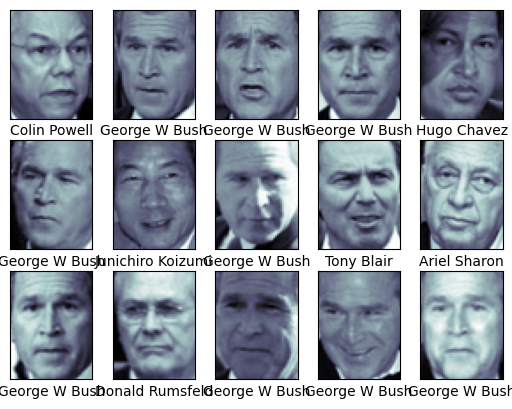

In [14]:
# Plot some faces
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

> Each image contains 62×47 or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [15]:
# I updated to use Pipeline instead of the text's make_pipeline
model = Pipeline([
   ('pca', PCA(n_components=150, whiten=True, random_state=42)),
   ('svc', SVC(kernel='rbf', class_weight='balanced'))
  ])

In [16]:
# Split the dataset into training and testing datasets
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

We kind of glossed over the bit above about how we "we had to choose and carefully tune our projection" and the same for the $C$ cost value. One way of figuring these values out is to test a bunch and see what works...

Luckily there is a `GridSearch` (and `GridScearchCV` that also does cross validation) that will test a set of parameters for us automatically.

In [17]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 16s, sys: 95 ms, total: 1min 16s
Wall time: 41.5 s
{'svc__C': 5, 'svc__gamma': 0.001}


In [18]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

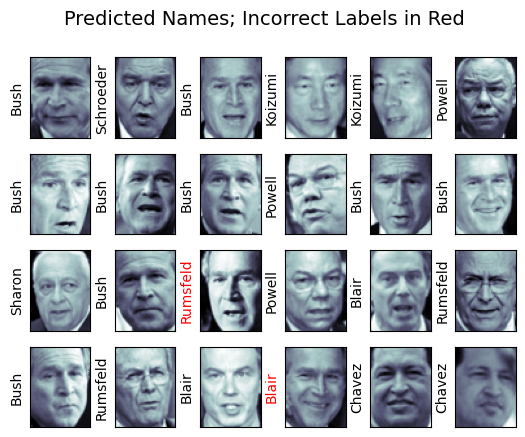

In [19]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [20]:

print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



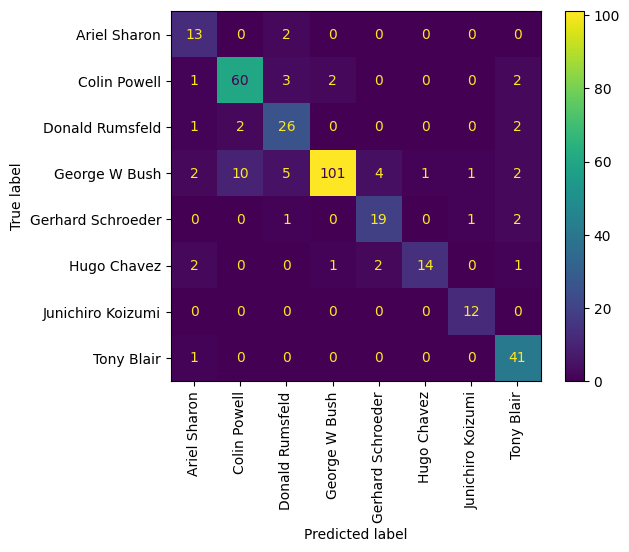

In [21]:
cm = confusion_matrix(ytest, yfit)
# Plot the confusion matrix
cm_display = ConfusionMatrixDisplay(cm, display_labels=faces.target_names).plot(xticks_rotation='vertical')